# Hands-on session on Digital Volume Correlation with <tt>SPAM
    
@ Olga Stamati: olga.stamati@esfr.fr

   

## Outline

- What is <tt>SPAM</tt>?
- Let's load an X-ray image
- Local DVC
- <font color="red">**Discrete DVC**</font>    
- Global DVC
- Multimodal registration

##  Input images

We'll use a pair of X-ray tomographies acquired during the triaxial compression of a small sample of a Martian Simulant soil, which is a convevient granular data set.

---
It should be already inside the folder `./M2EA`  <br>
If for any strange reason you can't find them, please download the `M2EA05.zip` file from [here](https://zenodo.org/record/3888347).


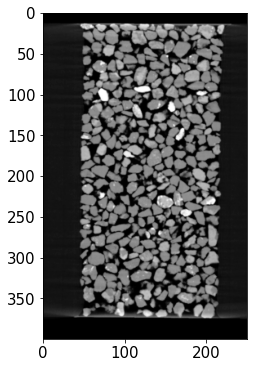

In [2]:
# Let's look at the data
import tifffile   
import spam.DIC
import matplotlib.pyplot as plt; plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15

grey = tifffile.imread("./M2EA/M2EA05-01-bin4.tif")

plt.figure(figsize=(6, 6))
plt.imshow(grey[:, :, grey.shape[2]//2], cmap="Greys_r"); plt.show()

### Image **binarisation** <br>

We're not going to spend time on this, since it has been already covered in previous lectures and practical sessions.

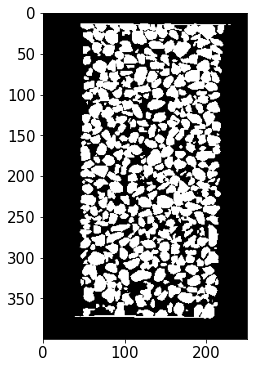

In [3]:
binary = grey >= 18000
plt.figure(figsize=(6, 6))
plt.imshow(binary[:, :, binary.shape[2]//2], cmap="Greys_r"); plt.show()

### Image segmentation<br>

Again this has been already covered in previous lectures and practical sessions.

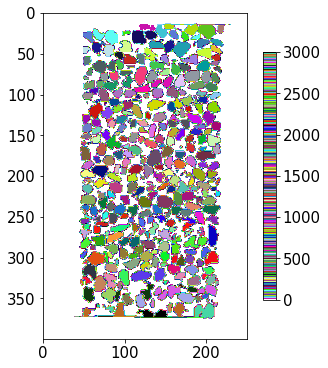

In [78]:
import spam.label
labelled = spam.label.watershed(binary)
tifffile.imsave("./M2EA/M2EA05-01-bin4-watershed.tif", labelled)

plt.figure(figsize=(6, 6))
plt.imshow(labelled[:, :, labelled.shape[2]//2], cmap=spam.label.randomCmap); plt.colorbar(shrink=0.76)
plt.show()

##  Reminder of correlation functional

We're trying to minimise the functional:<br>

$ \hspace{2.5cm} \mathcal{T}(\boldsymbol{\Phi}) = \sum_{x \in \Omega} \left(f(x) - g(\boldsymbol{\Phi}\cdot x)\right)^2 \hspace{0.6cm}$

Until now me measured:
- a **single** deformation function (`spam-reg`), where $\Omega$ includes all the pixels of the **image**
- a **field** of deformation functions defined in a regular grid (`spam-ldic`), where we had **many independent** $\Omega$, each including all the pixels inside a **correlation window**


## From the <font color="red">grid</font> for <font color="red">Local</font> DVC:

<center>
    
<img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/regularGridSmall.png" width="320" height="320" />

## To the <font color="red">labels</font> for <font color="red">Discrete</font> DVC:

<center>
    
<img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/discrete.png" width="800" height="800" />

##  Initial guess

The first step requires again to compute an initial guess.<br>

---
**NOTE 1**:<br>

**<font color="red">Registration</font>** is very useful when the transformation is **homogeneous** (such as a large rigid-body rotation).<br>

What should we do in case of a **large heterogeneous transformation** ?<br>
**<font color="red">Pixel-search</font>**: alternative initial guess coming from a brute-force **cross-correlation**

---
**NOTE 2**:<br>
We can use **both** a <font color="red">**registration**</font> and a <font color="red">**pixel-search**</font> for initial guesses

### Pixel-search as an initial guess

We aim to capture an heterogeneous deformation field under large deformations.

- We should look **locally**
- We use **correlation windows**: now you know, they can be defined on a grid or around each particle
---
- We forget about the iterative gradient-based algorithm
---
- We perform interger voxel shifts (in 3 directions) of the correlation windows inside a bounded search range
- We look for the best combination of these shifts that we'll give the highest Correlation Coefficient between the image subvolumes


In [82]:
! spam-pixelSearch M2EA/M2EA05-01-bin4.tif M2EA/M2EA05-02-bin4.tif \
                  -lab1 M2EA/M2EA05-01-bin4-watershed.tif \
                  -ld 1 \
                  -sr -4 4 -2 2 -2 2
                   

I have been passed a labelled image and so I am disactivating node spacing and half-window size and mask and setting mask coverage to 0
spam-pixelSearch -- Current Settings:
	APPLY_F: all
	GREY_HIGH_THRESH: inf
	GREY_LOW_THRESH: -inf
	HWS: None
	LAB1: <_io.TextIOWrapper name='M2EA/M2EA05-01-bin4-watershed.tif' mode='r' encoding='UTF-8'>
	LABEL_DILATE: 1
	LABEL_VOLUME_THRESHOLD: 100
	MASK1: None
	MASK2: None
	MASK_COVERAGE: 0
	NS: None
	OUT_DIR: M2EA
	PHIFILE: None
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: M2EA05-01-bin4-M2EA05-02-bin4-pixelSearch
	PROCESSES: 8
	SEARCH_RANGE: [-4, 4, -2, 2, -2, 2]
	TIFF: False
	TSV: True
	VTK: False
	im1: <_io.TextIOWrapper name='M2EA/M2EA05-01-bin4.tif' mode='r' encoding='UTF-8'>
	im2: <_io.TextIOWrapper name='M2EA/M2EA05-02-bin4.tif' mode='r' encoding='UTF-8'>

	Starting Pixel search (with 8 processes)
  CC=0.97434  |##################################################| Time: 0:00:07




	spam.tsvio.readCorrelationTSV(): Number of labels: 3007


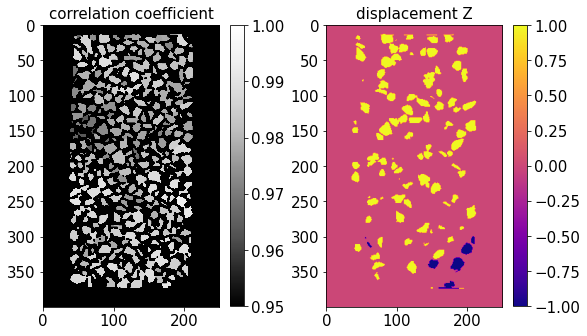

In [89]:
import spam.helpers
PhiFile  = spam.helpers.readCorrelationTSV("./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-pixelSearch.tsv", readPixelSearchCC=True)
CC       = PhiFile["pixelSearchCC"]
PhiField = PhiFile["PhiField"]

dispZ = spam.label.convertLabelToFloat(labelled, PhiField[:, :-1, -1])
CC    = spam.label.convertLabelToFloat(labelled, CC)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1); plt.title("correlation coefficient", fontsize=15)
plt.imshow(CC[:, CC.shape[1]//2], cmap="Greys_r", vmin=0.95, vmax=1); plt.colorbar(shrink=0.5)
plt.subplot(1,2,2); plt.title("displacement Z", fontsize=15)
plt.imshow(dispZ[:, dispZ.shape[1]//2], cmap="plasma"); plt.colorbar(shrink=0.5)
plt.tight_layout(); plt.show()

In [92]:
! spam-ddic M2EA/M2EA05-01-bin4.tif M2EA/M2EA05-01-bin4-watershed.tif \
            M2EA/M2EA05-02-bin4.tif \
            -pf ./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-pixelSearch.tsv \
            -ld 1


spam-ddic -- Current Settings:
	APPLY_F: rigid
	CORRELATE_RIGID: True
	DEBUG: False
	INTERPOLATION_ORDER: 1
	LABEL_DILATE: 1
	MARGIN: 5
	MASK_OTHERS: True
	MAX_ITERATIONS: 50
	MIN_PHI_CHANGE: 0.001
	MULTISCALE_BINNING: 1
	OUT_DIR: M2EA
	PHIFILE: <_io.TextIOWrapper name='./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-pixelSearch.tsv' mode='r' encoding='UTF-8'>
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: M2EA05-01-bin4-M2EA05-02-bin4
	PROCESSES: 8
	SKIP_PARTICLES: False
	UPDATE_GRADIENT: False
	VOLUME_THRESHOLD: 100
	im1: <_io.TextIOWrapper name='M2EA/M2EA05-01-bin4.tif' mode='r' encoding='UTF-8'>
	im2: <_io.TextIOWrapper name='M2EA/M2EA05-02-bin4.tif' mode='r' encoding='UTF-8'>
	lab1: <_io.TextIOWrapper name='M2EA/M2EA05-01-bin4-watershed.tif' mode='r' encoding='UTF-8'>

spam-ddic: Loading Data...done.
spam-ddic: Number of labels = 3006

spam-ddic: Calculating Bounding Boxes and Centres of Mass of all labels.


	spam.tsvio.readCorrelationTSV(): Number of labels: 3007

	Starting Discrete DIC (with 8 processe

In [28]:
! ls -l ./M2EA/*ddic*

-rw-rw-r-- 1 ostamati ostamati 749097 mai   29 18:48 ./M2EA/M2EA05-01-bin2-M2EA05-02-bin2-ddic.tsv
-rw-rw-r-- 1 ostamati ostamati 478741 mai   29 18:48 ./M2EA/M2EA05-01-bin2-M2EA05-02-bin2-ddic.vtk
-rw-rw-r-- 1 ostamati ostamati 726036 mai   29 18:37 ./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.tsv
-rw-rw-r-- 1 ostamati ostamati 470143 mai   29 18:37 ./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.vtk
-rw-rw-r-- 1 ostamati ostamati 728449 mai   29 18:26 ./M2EA/M2EA05-01-bin4-M2EA05-03-bin4-ddic.tsv
-rw-rw-r-- 1 ostamati ostamati 468609 mai   29 18:26 ./M2EA/M2EA05-01-bin4-M2EA05-03-bin4-ddic.vtk


	spam.tsvio.readCorrelationTSV(): Number of labels: 3007


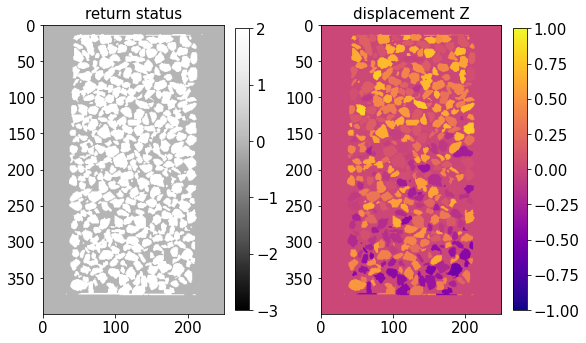

In [93]:
import spam.helpers
PhiFile  = spam.helpers.readCorrelationTSV("./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.tsv")
PhiField = PhiFile["PhiField"]
RS       = PhiFile["returnStatus"]

dispZ = spam.label.convertLabelToFloat(labelled, PhiField[:, :-1, -1])
RS    = spam.label.convertLabelToFloat(labelled, RS)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1); plt.title("return status", fontsize=15)
plt.imshow(RS[:, RS.shape[1]//2], cmap="Greys_r", vmin=-3, vmax=2); plt.colorbar(shrink=0.5)
plt.subplot(1,2,2); plt.title("displacement Z", fontsize=15)
plt.imshow(dispZ[:, dispZ.shape[1]//2], cmap="plasma", vmin=-1, vmax=1); plt.colorbar(shrink=0.5)
plt.tight_layout(); plt.show()

## Compute strains from a discrete correlation

- Project discrete displacement field into a regular grid and compute strains as we did for local DVC
- Discrete strain mode using tetrahedra tesselation

## Compute strains from a discrete correlation

- Project discrete displacement field into a regular grid and compute strains as we did for local DVC
    1. Project the discrete field using `spam-passPhiField`

In [51]:
! spam-passPhiField -im1 ./M2EA/M2EA05-01-bin4-watershed.tif \
                    -pf ./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.tsv \
                    -ns 10 -vtk



No labelled image so I'm in grid mode
Getting im1 dimensions by looking in the file (this ignores -im1shape)
spam-passPhiField -- Current Settings:
	APPLY_F: all
	CHECK_POINT_SURROUNDED: False
	LAB1: []
	MERGE_PREFER_LABEL: False
	NEIGHBOUR_RADIUS: None
	NS: [10, 10, 10]
	NUMBER_OF_NEIGHBOURS: None
	OUT_DIR: ./M2EA
	PHIFILE: <_io.TextIOWrapper name='./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.tsv' mode='r' encoding='UTF-8'>
	PHIFILE2: []
	PHIFILE2_BIN_RATIO: 1
	PHIFILE_BIN_RATIO: 1.0
	PREFIX: M2EA05-01-bin4-M2EA05-02-bin4-ddic-passed-ns10
	PROCESSES: 8
	REGISTRATION_SUBTRACT_APPLY_F: rigid
	REGISTRATION_SUBTRACT_BIN_RATIO: 1
	REGISTRATION_SUBTRACT_FILE: None
	RETURN_STATUS_THRESHOLD: -4
	TIFF: False
	VTK: True
	im1: <_io.TextIOWrapper name='./M2EA/M2EA05-01-bin4-watershed.tif' mode='r' encoding='UTF-8'>
	im1shape: (400, 250, 250)
	spam.tsvio.readCorrelationTSV(): Number of labels: 3007
Neither number of neighbours nor neighbour distance set, using default distance of 2*mean(NS) = 20

S

## Compute strains from a discrete correlation

- Project discrete displacement field into a regular grid (and compute strains as we did for local DVC)
    1. Project the discrete field using `spam-passPhiField`
    2. Compute regular strains using `spam-regularStrain`

In [71]:
! spam-regularStrain ./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic-passed-ns10.tsv -rst 1 -cub -comp dev vol -tif

+----------------------------+
| Regular Strain Calculation |
+----------------------------+

Current Settings:
	COMPONENTS: ['dev', 'vol']
	MASK: True
	OUT_DIR: ./M2EA
	PREFIX: M2EA05-01-bin4-M2EA05-02-bin4-ddic-passed-ns10
	PROCESSES: 8
	Q8: True
	RAW: False
	RETURN_STATUS_THRESHOLD: 1
	STRAIN_NEIGHBOUR_RADIUS: 1.5
	TIFF: True
	TSV: True
	VTK: False
	VTKmaskNAN: True
	inFile: <_io.TextIOWrapper name='./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic-passed-ns10.tsv' mode='r' encoding='UTF-8'>

spam-regularStrain: Loading data...
	spam.tsvio.readCorrelationTSV(): Field dimensions: [39 24 24]

spam-regularStrain: excluding points based on return threshold < 1 (excluded 100.0%)

spam-regularStrain: Computing F=I+du/dx
100% |#########################################################################|

spam-regularStrain: Decomposing F into  ['dev', 'vol']
100% |#########################################################################|

spam-regularStrain: Saving strain fields...


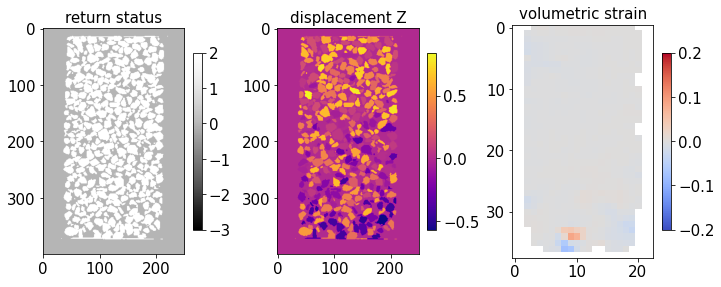

In [74]:
vol = tifffile.imread("./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic-passed-ns10-vol-Q8.tif")

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.title("return status", fontsize=15)
plt.imshow(RS[:, RS.shape[1]//2], cmap="Greys_r", vmin=-3, vmax=2); plt.colorbar(shrink=0.25)
plt.subplot(1,3,2)
plt.title("displacement Z", fontsize=15)
plt.imshow(dispZ[:, dispZ.shape[1]//2], cmap="plasma"); plt.colorbar(shrink=0.25)
plt.subplot(1,3,3)
plt.title("volumetric strain", fontsize=15)
plt.imshow(vol[:, vol.shape[1]//2], cmap="coolwarm", vmin=-.2, vmax=0.2); plt.colorbar(shrink=0.25)
plt.tight_layout(); plt.show()

## Compute strains from a discrete correlation

- Project discrete displacement field into a regular grid and compute strains as we did for local DVC
- <font color="red">Discrete strain mode using tetrahedra tesselation</font>

In [64]:
! spam-discreteStrain ./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.tsv \
                      -rl ./M2EA/M2EA05-01-bin4-watershed.tif \
                      -a 300 -tri

spam-discreteStrain -- Current Settings:
	COMPONENTS: ['vol', 'dev']
	KEEP_ZERO: False
	OUT_DIR: ./M2EA
	PREFIX: M2EA05-01-bin4-M2EA05-02-bin4-ddic-strains
	PROCESSES: 8
	PROJECT_TO_GRAINS: False
	RADII_LABELLED_FILE: ./M2EA/M2EA05-01-bin4-watershed.tif
	RADII_TSV_FILE: None
	RETURN_STATUS_THRESHOLD: None
	TRI: True
	TRI_ALPHA: 300.0
	TRI_FILE: None
	VTKmaskNAN: True
	inFile: <_io.TextIOWrapper name='./M2EA/M2EA05-01-bin4-M2EA05-02-bin4-ddic.tsv' mode='r' encoding='UTF-8'>

spam-discreteStrain: Loading kinematics...
	spam.tsvio.readCorrelationTSV(): Number of labels: 3007

spam-discreteStrain: 16062 tetrahedra created
spam-discreteStrain: 3006 nodes considered
spam-discreteStrain: Computing F=I+du/dx for all tetrahedra
100% |#########################################################################|

spam-discreteStrain: Decomposing F into  ['vol', 'dev'] for all tetrahedra
100% |#########################################################################|

spam-discreteStrain: Saving VTK 

## Visualise the discrete tessellated strain field

Unfortunately this is an unstructured mesh... So we need to load it in a suitable software (here ParaView) to visualise it.<br>

It should look like this...

<center>
    
<img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/strainTetAnim.gif" width="550" height="550" />

## Grain tracking from discrete correlations

There are functions in <tt>SPAM</tt> that allow you to track your discrete objects through timeseries images

<center>
    
<img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/LENGP04-greyLab.gif" width="550" height="550" />

## Grain tracking from discrete correlations

There are functions in <tt>SPAM</tt> that allow you to track your discrete objects through timeseries images
<center>
    
<img src="https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/_images/arrows.gif" width="550" height="550" />

## Discrete Image Correlation Summary

- Requires the segmentation of your greyscale image into relevant objects (particles, bands, fibres, etc...)
- Belongs to the **local** correlation approaches
- A seperate correlation window for each labelled object
- Deformation field at the object scale (displacement/rotation and even strain)
- Strain field at the object, but also at the specimen scale
- For an image series: Particle Tracking

---
Detailed tutorial and tricks [here](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/tutorials/tutorial-04-discreteDIC.html)